In [1]:
from tqdm import tqdm
from tqdm import notebook
from datetime import datetime as dt
import pickle
import random
import os
import string
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt


from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, concatenate, RepeatVector, TimeDistributed, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential

from nltk.translate.bleu_score import corpus_bleu


from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
config = {
	'images_path': 'drive/My Drive/Flickr8kDataset/Flicker8k_Dataset/', #Make sure you put that last slash(/)
	'train_data_path': 'drive/My Drive/Flickr8kText/Flickr_8k.trainImages.txt',
	'val_data_path': 'drive/My Drive/Flickr8kText/Flickr_8k.devImages.txt',
	'captions_path': 'drive/My Drive/Flickr8kText/Flickr8k.token.txt',
	'test_data_path' : 'drive/My Drive/Flickr8kText/Flickr_8k.testImages.txt',
	'tokenizer_path' : 'drive/My Drive/tokenizer.pkl',
	'model_type' : 'vgg16',
	'batch_size': 64,
	'beam_search_k':3,
	'num_of_epochs': 20,
	'model_data_path' :'drive/My Drive/',
	'random_seed' : 2,
	'model_load_path' : 'drive/My Drive/model.h5'
}

rnnConfig = {
	'embedding_size': 300,
	'LSTM_units': 256,
	'dense_units': 256,
	'dropout': 0.3
}

In [4]:
# contains the ids of either the train/val images accroding to the filename provided

def load_set(filename):
	file = open(filename, 'r')
	doc = file.read()
	file.close()
	ids = list()
	# Process line by line
	for line in doc.split('\n'):
		# Skip empty lines
		if len(line) < 1:
			continue
		# Get the image identifier(id)
		_id = line.split('.')[0]
		ids.append(_id)
	return set(ids)
 

# Cleaning of captions and addition of the start and end tokens as an identifier is also done here
def load_cleaned_captions(filename, ids):
	file = open(filename, 'r')
	doc = file.read()
	file.close()
	captions = dict()
	_count = 0
	# Process line by line
	for line in doc.split('\n'):
		# Split line on white space
		tokens = line.split()
		# Split id from caption
		image_id, image_caption = tokens[0], tokens[1:]
		# Skip images not in the ids set
		if image_id in ids:
			# Create list
			if image_id not in captions:
				captions[image_id] = list()
			# Wrap caption in start & end tokens
			caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
			# Store
			captions[image_id].append(caption)
			_count = _count+1
	return captions, _count

# Load the feature vector of the images
def load_image_features(filename, ids):
	# load all features
	all_features = pickle.load(open(filename, 'rb'))
	# filter features
	# print(ids)
	features = {_id: all_features[_id] for _id in ids}
	return features

# save all captions in a list
def to_lines(captions):
	all_captions = list()
	for image_id in captions.keys():
		[all_captions.append(caption) for caption in captions[image_id]]
	return all_captions

# create a tokenizer for tokenizing the captions
def create_tokenizer(captions):
	lines = to_lines(captions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# Calculate the length of the captions with the most words
def calc_max_length(captions):
	lines = to_lines(captions)
	return max(len(line.split()) for line in lines)
 


def create_sequences(tokenizer, max_length, captions_list, image):
	# X1 : input for image features
	# X2 : input for text features
	# y  : output word
	X1, X2, y = list(), list(), list()
	vocab_size = len(tokenizer.word_index) + 1
	# Walk through each caption for the image
	for caption in captions_list:
		# Encode the sequence
		seq = tokenizer.texts_to_sequences([caption])[0]
		# Split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# Split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# Pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# Encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# Store
			X1.append(image)
			X2.append(in_seq)
			y.append(out_seq)
	return X1, X2, y

# Data generator, intended to be used in a call to model.fit_generator()
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed):
	# Setting random seed for reproducibility of results
	random.seed(random_seed)
	# Image ids
	image_ids = list(captions.keys())
	_count=0
	assert batch_size<= len(image_ids), 'Batch size must be less than or equal to {}'.format(len(image_ids))
	while True:
		if _count >= len(image_ids):
			# Generator exceeded or reached the end so restart it
			_count = 0
		# Batch list to store data
		input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
		for i in range(_count, min(len(image_ids), _count+batch_size)):
			# Retrieve the image id
			image_id = image_ids[i]
			# Retrieve the image features
			image = images[image_id][0]
			# Retrieve the captions list
			captions_list = captions[image_id]
			# Shuffle captions list
			random.shuffle(captions_list)
			input_img, input_sequence, output_word = create_sequences(tokenizer, max_length, captions_list, image)
			# Add to batch
			for j in range(len(input_img)):
				input_img_batch.append(input_img[j])
				input_sequence_batch.append(input_sequence[j])
				output_word_batch.append(output_word[j])
		_count = _count + batch_size
		yield [[np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch)]

In [5]:
def CNNModel(model_type):
  if model_type == 'inceptionv3':
    base_model = InceptionV3()
  if model_type == 'vgg16':
    base_model = VGG16()

  model = Sequential()
  for layer in base_model.layers[:-1]:
    model.add(layer)
  return model


def RNNModel(vocab_size, max_len, rnnConfig,  model_type):
  embedding_size = rnnConfig["embedding_size"]

  if(model_type == "inceptionv3"):
    input_layer = Input(shape = (2048,) )
  elif(model_type == "vgg16"):
    input_layer = Input(shape =  (4096, ) )

  image_model1 = Dropout(rnnConfig["dropout"])(input_layer)
  image_model = Dense(embedding_size,activation = "relu")(image_model1)

  caption_input = Input(shape = (max_len, ))
  caption_model1 = Embedding(vocab_size,embedding_size,mask_zero=True)(caption_input)
  caption_model2 = Dropout(rnnConfig["dropout"])(caption_model1)
  caption_model = LSTM(rnnConfig["LSTM_units"])(caption_model2)

  final_model_1 = concatenate([image_model, caption_model])
  final_model_2 = Dense(rnnConfig["dense_units"], activation= 'relu')(final_model_1)
  final_model =  Dense(vocab_size, activation = 'softmax')(final_model_2)

  model = Model(inputs = [input_layer, caption_input], outputs = final_model)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
  return model


def int_to_word(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None


def generate_caption(model , tokenizer, image, max_length):
  #seed
  in_text = 'startseq'

  for _ in range(max_length):
    sequence = tokenizer.texts_sequence([in_text])[0]

    #padding sequence
    sequence = pad_sequences([sequence], maxlength = max_length )

    #predict next word
    yhat = model.predict([image, sequence], verbose = 0)
    yhat = np.argmax(yhat)

    word = int_to_word(yhat, tokenizer)

    if word is None:
      break
    
    intext += ' ' + word

    if word == 'endseq':
      break
    
  return in_text

def generate_caption_beam_search(model, tokenizer, image, max_length, beam_index = 3):
  # in_text  ----> [[idx, prob]] ; prob = 0 initially
  in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
  while len(in_text[0][0]) < max_length:
    temp_list = []
    for seq in in_text:
      padded_seq = pad_sequences([seq[0]] , maxlen = max_length)
      preds = model.predict( [image, padded_seq], verbose = 0)

      top_preds = np.argsort(preds[0])[-beam_index:]
      # Getting the top `beam_index` predictions and 
      for word in top_preds:
        next_seq, prob = seq[0][:], seq[1]
        next_seq.append(word)
        prob += preds[0][word]

        #Append as input for generating the next word
        temp_list.append([next_seq,prob])
      
    in_text = temp_list
    in_text = sorted(in_text, reverse=False, key=lambda l: l[1])

    #take the top words
    in_text = in_text[-beam_index:]
  in_text = in_text[-1][0]
  final_caption_raw = [int_to_word(i,tokenizer) for i in in_text]
  final_caption = []
  for word in final_caption_raw:
    if(word == 'endseq'):
      break
    else:
      final_caption.append(word)
  final_caption.append('endseq')
  return ' '.join(final_caption)







 

In [6]:
#Preprocessing
def extract_features(path, model_type):
  if(model_type == 'inceptionv3'):
    from keras.applications.inception_v3 import preprocess_input
    target_size = (299,299)
  elif(model_type == 'vgg16'):
    from keras.applications.vgg16 import preprocess_input
    target_size = (224,224)
  
  model = CNNModel(model_type)
  features = {}

  for name in notebook.tqdm(os.listdir(path)):
    #loading and resizing image
    filename = path+name
    image = load_img(filename, target_size = target_size)
    #convert the image pixels to numpy array
    image = img_to_array(image)
    #reshape for the model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    #prepare the image for the CNN Model
    image = preprocess_input(image)
    #pass image to model to get encoded feature
    feature = model.predict(image)
    #store encoded feature for the image
    image_id = name.split('.')[0]
    features[image_id] = feature
  return features

In [8]:
def load_captions(filename):
	file = open(filename, 'r')
	doc = file.read()
	file.close()
	"""
	Captions dict is of form:
	{
		image_id1 : [caption1, caption2, etc],
		image_id2 : [caption1, caption2, etc],
		...
	}
	"""
	captions = dict()
	# Process lines by line
	_count = 0
	for line in doc.split('\n'):
		# Split line on white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# Take the first token as the image id, the rest as the caption
		image_id, image_caption = tokens[0], tokens[1:]
		# Extract filename from image id
		image_id = image_id.split('.')[0]
		# Convert caption tokens back to caption string
		image_caption = ' '.join(image_caption)
		# Create the list if needed
		if image_id not in captions:
			captions[image_id] = list()
		# Store caption
		captions[image_id].append(image_caption)
		_count = _count+1
	# print('{}: Parsed captions: {}'.format(mytime(),_count))
	return captions

def clean_captions(captions):
	# Prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for _, caption_list in captions.items():
		for i in range(len(caption_list)):
			caption = caption_list[i]
			# Tokenize i.e. split on white spaces
			caption = caption.split()
			# Convert to lowercase
			caption = [word.lower() for word in caption]
			# Remove punctuation from each token
			caption = [w.translate(table) for w in caption]
			# Remove hanging 's' and 'a'
			caption = [word for word in caption if len(word)>1]
			# Remove tokens with numbers in them
			caption = [word for word in caption if word.isalpha()]
			# Store as string
			caption_list[i] =  ' '.join(caption)

"""
	*Save captions to file, one per line
	*After saving, captions.txt is of form :- `id` `caption`
		Example : 2252123185_487f21e336 stadium full of people watch game
"""
def save_captions(captions, filename):
	lines = list()
	for key, captions_list in captions.items():
		for caption in captions_list:
			lines.append(key + ' ' + caption)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 

def preprocessData(config):
	print('Using {} model'.format(config['model_type'].title()))
	# Extract features from all images
	features = extract_features(config['images_path'], config['model_type'])
	# Save to file
	pickle.dump(features, open('drive/My Drive/'+'features_'+str(config['model_type'])+'.p', 'ab'))


	# Load file containing captions and parse them
	captions = load_captions(config['captions_path'])
	# Clean captions
	# Ignore this function because Tokenizer from keras will handle cleaning
	# clean_captions(captions)
	# Save captions
	save_captions(captions, 'drive/My Drive/'+'captions.txt')



In [9]:
def loadTrainData(config):
	train_image_ids = load_set(config['train_data_path'])
	# Check if we already have preprocessed data saved and if not, preprocess the data.
	# Create and save 'captions.txt' & features.pkl
	##preprocessData(config)
	# Load captions
	train_captions, _count = load_cleaned_captions('drive/My Drive/'+'captions.txt', train_image_ids)
	# Load image features
	train_image_features = load_image_features('drive/My Drive/'+'features_'+str(config['model_type'])+'.p', train_image_ids)
	if not os.path.exists(config['tokenizer_path']):
		# Prepare tokenizer
		tokenizer = create_tokenizer(train_captions)
		# Save the tokenizer
		pickle.dump(tokenizer, open(config['tokenizer_path'], 'ab'))
	# Determine the maximum sequence length
	max_length = calc_max_length(train_captions)
	return train_image_features, train_captions, max_length

def loadValData(config):
	val_image_ids = load_set(config['val_data_path'])
	# Load captions
	val_captions, _count = load_cleaned_captions('drive/My Drive/'+'captions.txt', val_image_ids)
	# Load image features
	val_features = load_image_features('drive/My Drive/'+'features_'+str(config['model_type'])+'.p', val_image_ids)
	# print('{}: Available images for validation: {}'.format(mytime(),len(val_features)))
	# print('{}: Available captions for validation: {}'.format(mytime(),_count))
	return val_features, val_captions


In [10]:
X1train, X2train, max_length = loadTrainData(config)

X1val, X2val = loadValData(config)

tokenizer = pickle.load(open(config['tokenizer_path'], 'rb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


7378


In [ ]:
model = RNNModel(vocab_size, max_length,rnnConfig,config['model_type'])
print('RNN Model Summary : ')
print(model.summary())

num_of_epochs = config['num_of_epochs']
batch_size = config['batch_size']
steps_train = len(X2train)//batch_size

if(len(X2train)%batch_size != 0 ):
  steps_train += 1

steps_val = len(X2val)/batch_size
if len(X2val)%batch_size != 0:
  steps_val += 1
model_save_path = config['model_data_path'] +"model_"+str(config['model_type'])+"_epoch-{epoch:02d}_train_loss-{loss:.4f}_val_loss-{val_loss:.4f}.hdf5"



print('steps_train: {}, steps_val: {}'.format(steps_train,steps_val))
print('Batch Size: {}'.format(batch_size))
print('Total Number of Epochs = {}'.format(num_of_epochs))


ids_train = list(X2train.keys())
random.shuffle(ids_train)
X2train_shuffled = {_id:X2train[_id] for _id in ids_train}
X2train = X2train_shuffled

#Create the train data generator
generator_train = data_generator(X1train, X2train, tokenizer, max_length, batch_size, config['random_seed'])

generator_val = data_generator(X1val, X2val, tokenizer, max_length, batch_size, config['random_seed'])

#Fit for one epoch
# model.fit_generator(generator_train, epochs = num_of_epochs, steps_per_epoch = steps_train, 
#                     validation_data = generator_val, validation_steps = steps_val,
#                     verbose = 1)
# model.save('drive/My Drive/model.h5')

print('Model trained successfully. Running model on validation set for calculating BLEU score using BEAM search with k={}'.format(config['beam_search_k']))
evaluate_model_beam_search(model, X1val, X2val, tokenizer, max_length, beam_index=config['beam_search_k'])


In [ ]:
def evaluate_model_beam_search(model, images, captions, tokenizer, max_length, beam_index=3):
	actual, predicted = list(), list()
	for image_id, caption_list in tqdm(captions.items()):
		yhat = generate_caption_beam_search(model, tokenizer, images[image_id], max_length, beam_index=beam_index)
		ground_truth = [caption.split() for caption in caption_list]
		actual.append(ground_truth)
		predicted.append(yhat.split())
	print('BLEU Scores :')
	print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 

print('Model trained successfully. Running model on validation set for calculating BLEU score using BEAM search with k={}'.format(config['beam_search_k']))
evaluate_model_beam_search(model, X1val, X2val, tokenizer, max_length, beam_index=config['beam_search_k'])


In [13]:
test_ids = open(config['test_data_path'],'r').read().split('\n')

test_images_path = []
for id in test_ids:
  test_images_path.append(config['images_path'] + id)

In [31]:
caption_model = load_model(config['model_load_path'])

def test_image(path,id):
  image_show = cv2.imread(path)
  image = load_image_features('drive/My Drive/'+'features_'+str(config['model_type'])+'.p',id)
  generated_caption = generate_caption_beam_search(caption_model, tokenizer, image[id[0]], max_length, beam_index=config['beam_search_k'])
  caption = 'Caption: ' + generated_caption.split()[1].capitalize()
  for x in generated_caption.split()[2:len(generated_caption.split())-1]:
      caption = caption + ' ' + x
  caption += '.'
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  _ = ax.imshow(cv2.cvtColor(np.asarray(image_show), cv2.COLOR_BGR2RGB), interpolation='nearest')
  _ = ax.set_title("BEAM Search with k={}\n{}".format(config['beam_search_k'],caption),fontdict={'fontsize': '20','fontweight' : '40'})
  plt.savefig('drive/My Drive/Outputs/'+'output--'+id[0] + '.jpg')


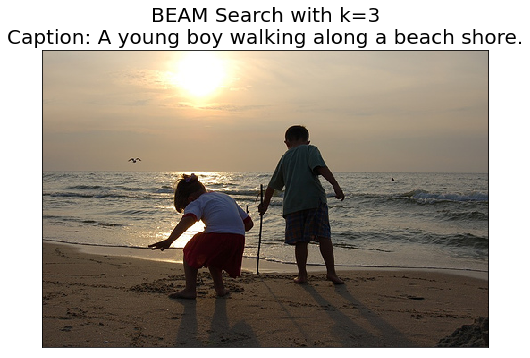

In [43]:
test_image(test_images_path[400],[test_ids[400].split('.')[0]])